# 扩展实验：MNIST手写数字角度回归
### 引入需要的python包

In [1]:
from __future__ import print_function
import numpy as np
import argparse
import os

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import cv2
from PIL import Image
import math

from sklearn.metrics import *
import matplotlib.pyplot as plt
%matplotlib inline

### 使用本地的图片与标签
#### 从本地文件中加在图片与标签的函数

In [2]:
class LocalDataset(Dataset):
    def __init__(self, root_dir, record_dir, transform):
        super(LocalDataset, self).__init__()
        self.transform = transform
        self.root_dir = root_dir
        self.datas = self.read_samples_from_record(root_dir, record_dir)
        
    def __getitem__(self, index):
        path, target = self.datas[index]
        sample = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        sample = Image.fromarray(sample)
        if self.transform is not None:
            sample = self.transform(sample)
        cos = math.cos(target/180*math.pi)
        sin = math.sin(target/180*math.pi)
        return sample, target, cos, sin
    
    def __len__(self):
        return len(self.datas)
    
    def read_samples_from_record(self, root_dir, record_dir):
        samples = []
        with open(record_dir, "r") as f:
            for index, line in enumerate(f):
                line = line.split()
                if len(line) < 2:
                    print('Error, Label is missing')
                    exit()
                else:
                    image_dir, label = line[0], line[1]
                label = int(label)
                image_dir = os.path.join(root_dir, image_dir)
                samples.append((image_dir, label))
        return samples

#### 加载数据

In [3]:
data_dir = 'data/mnist/' #放置本地mnist数据集的地址
train_label = 'data/mnist/mnist_rotation_train.txt'
test_label = 'data/mnist/mnist_rotation_test.txt'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

train_set = LocalDataset(data_dir, train_label, transform)

train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=64,
    shuffle=True)

test_set = LocalDataset(data_dir, test_label, transform)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=64,
    shuffle=True)

### 查看数据集中的图片样本

In [4]:
def imshow(img):
    arr = img.numpy()
    plt.imshow(np.transpose(arr, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MNIST number angle: 
  -34    40     3    42    41    15   -25    37
   17     7    43    39   -22    36    41   -35
  -13   -14   -34   -35    -4   -34   -20   -29
   19    32   -19   -20    16   -32     6    17


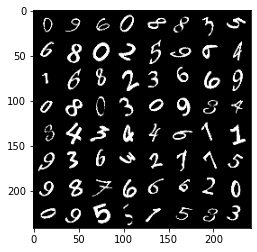

In [5]:
data = iter(train_loader)
images, labels, labels_cos, labels_sin = data.next()
imshow(torchvision.utils.make_grid(images))
print('MNIST number angle: ')
labels = np.array(labels)
for i in range(4):
    cur_out = labels[i*8:(i+1)*8]
    res = ' '.join('%5s' % cur_out[j] for j in range(8))
    print(res)

### 搭建神经网络类CNN--此网络进行手写数字分类

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### 在上述模型基础上替换最后一层，将分类网络修改为回归网络

In [7]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 2) # 最后一个fc层的输出尺寸变了

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 使用CNN2类创建神经网络模型
#### 查看比较两个网络模型的不同

In [8]:
old_model = CNN()
print('---------------CNN----------------')
for i in old_model._modules.items():
    print(i)
    
print('---------------CNN2----------------')
model = CNN2()
for i in model._modules.items():
    print(i)

---------------CNN----------------
('conv1', Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1)))
('conv2', Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1)))
('fc1', Linear(in_features=800, out_features=500, bias=True))
('fc2', Linear(in_features=500, out_features=10, bias=True))
---------------CNN2----------------
('conv1', Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1)))
('conv2', Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1)))
('fc1', Linear(in_features=800, out_features=500, bias=True))
('fc2', Linear(in_features=500, out_features=2, bias=True))


### 将预训练的分类网络的前几层参数加载到回归模型中

In [9]:
state_dict = torch.load('weights/mnist-epoch10.pth')
state_dict.pop('fc2.weight')
state_dict.pop('fc2.bias')

model_dict = model.state_dict()
model_dict.update(state_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

### 训练函数

In [10]:
def train(model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    loss_func = torch.nn.MSELoss() #更换分类用的nll loss为MSE loss
    for batch_idx, (data, target, target_cos, target_sin) in enumerate(train_loader):
        data, target, target_cos, target_sin = data.to(device), target.to(device).float(), target_cos.to(device).float(), target_sin.to(device).float()
        optimizer.zero_grad()
        output = model(data)
        output1 = output[:,0]
        output2 = output[:,1]
        #print(output1, target_cos)
        loss = loss_func(output1, target_cos) + loss_func(output2, target_sin)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx > 0 and batch_idx % 25 == 0:
            print('Train Epoch: {} [{}/{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            #print(model.state_dict()['fc2.weight'])
            #print(model.state_dict()['fc2.bias'])
    return losses

### 测试函数

In [11]:
def test(model, device, test_loader):
    model.eval()
    test_loss1 = 0
    test_loss2 = 0
    loss_func = torch.nn.MSELoss(reduction='sum') #更换分类用的nll loss为MSE loss
    with torch.no_grad():
        for data, target, target_cos, target_sin in test_loader:
            data, target, target_cos, target_sin = data.to(device), target.to(device).float(), target_cos.to(device).float(), target_sin.to(device).float()
            output = model(data)
            output1 = output[:,0]
            output2 = output[:,1]
            test_loss1 += loss_func(output1, target_cos).item() # sum up batch loss
            test_loss2 += loss_func(output2, target_sin).item()
    test_loss1 /= len(test_loader.dataset)
    test_loss2 /= len(test_loader.dataset)
    print('\nTest set: Cosine Average loss: {:.4f}, Sin Average loss: {:.4f}'.format(test_loss1, test_loss2))

### 冻结前几层的参数（微调模型，只训练最后一层的参数）

In [12]:
for name, value in model.named_parameters():
    if name != 'fc2.weight' and name != 'fc2.bias':
        value.requires_grad = False
        
params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

In [13]:
print('Trainable parameters:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, '\t',param.numel())

Trainable parameters:
fc2.weight 	 1000
fc2.bias 	 2


### 设置其他模型训练的参数

In [14]:
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cpu") # or 'gpu'
losses = []
epochs = 100

### 训练模型

In [15]:
for epoch in range(epochs):
    losses.extend(train(model, device, train_loader, optimizer, epoch))
    test(model, device, train_loader)

Train Epoch: 0 [1600/8000	(20%)]	Loss: 0.255410
Train Epoch: 0 [3200/8000	(40%)]	Loss: 0.216795
Train Epoch: 0 [4800/8000	(60%)]	Loss: 0.193803
Train Epoch: 0 [6400/8000	(80%)]	Loss: 0.161972

Test set: Cosine Average loss: 0.0539, Sin Average loss: 0.0905
Train Epoch: 1 [1600/8000	(20%)]	Loss: 0.151753
Train Epoch: 1 [3200/8000	(40%)]	Loss: 0.114443
Train Epoch: 1 [4800/8000	(60%)]	Loss: 0.117317
Train Epoch: 1 [6400/8000	(80%)]	Loss: 0.101600

Test set: Cosine Average loss: 0.0348, Sin Average loss: 0.0770
Train Epoch: 2 [1600/8000	(20%)]	Loss: 0.098006
Train Epoch: 2 [3200/8000	(40%)]	Loss: 0.107970
Train Epoch: 2 [4800/8000	(60%)]	Loss: 0.103030
Train Epoch: 2 [6400/8000	(80%)]	Loss: 0.095361

Test set: Cosine Average loss: 0.0252, Sin Average loss: 0.0715
Train Epoch: 3 [1600/8000	(20%)]	Loss: 0.089757
Train Epoch: 3 [3200/8000	(40%)]	Loss: 0.099211
Train Epoch: 3 [4800/8000	(60%)]	Loss: 0.075311
Train Epoch: 3 [6400/8000	(80%)]	Loss: 0.091870

Test set: Cosine Average loss: 0.020

KeyboardInterrupt: 

### 保存训好的模型参数

In [16]:
OUT_PATH = 'weights/mnist-rotation-epoch'+str(epochs)+'.pth'
torch.save(model.state_dict(), OUT_PATH)

### 绘制训练过程中的loss下降曲线

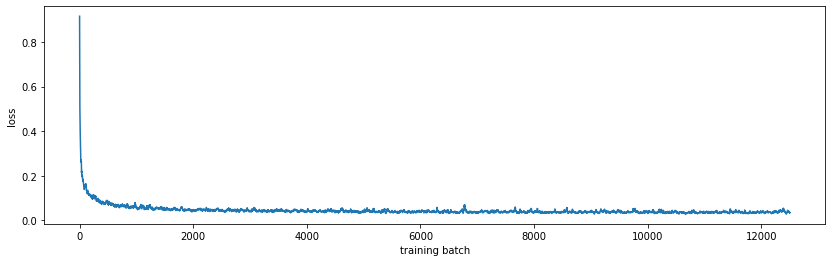

In [17]:
def mean(li): return sum(li)/len(li)
plt.figure(figsize=(14, 4))
plt.xlabel('training batch')
plt.ylabel('loss')
plt.plot([mean(losses[i:i+10]) for i in range(len(losses))])

### 查看测试集上的图片样本

In [ ]:
data = iter(test_loader)
images, labels, _, _ = data.next()
imshow(torchvision.utils.make_grid(images))
print('MNIST number angle: ')
labels = np.array(labels)
for i in range(8):
    cur_out = labels[i*8:(i+1)*8]
    res = ' '.join('%5s' % cur_out[j] for j in range(8))
    print(res)

### 查看对应模型输出

In [19]:
model.eval()
outputs = model(images)
predicted = []
for out in outputs:
    if out[0]>=-1 and out[0]<=1:
        angle = math.acos(out[0])/math.pi*180
        if out[1]<0:
            angle = -angle
    elif out[1]>=-1 and out[1]<=1:
        angle = math.asin(out[1])/math.pi*180
        if out[0]<0:
            angle = 180 - angle
    else:
        angle = 0
    predicted.append(angle)
print('Predicted: ')
predicted = np.array(predicted)
for i in range(8):
    cur_out = predicted[i*8:(i+1)*8]
    res = ' '.join('%5s' % int(cur_out[j]) for j in range(8))
    print(res)

Predicted: 
  -20    28   -19    11     9    29    19     9
  -26   -18   -32   -23   -17   -28   -14    27
   -6    -8   -25     2   -32     2    -5   -23
    5   -15    -9   -11    28    13     3   -20
  -10   -36    -5   -16   -33    18    31    16
   11   -20    28   -20   -20   -17   -14   -25
   25    -2    19   -14   -33    31    38   -17
    2    31    28    16    11   -12    -2    34


### 绘制旋转后的图像

In [20]:
def rotate(imgs, angles):
    res = []
    for i in range(imgs.shape[0]):
        img = imgs[i,:,:,:]
        angle = angles[i]
        arr = img.numpy()
        arr = np.transpose(arr, (1, 2, 0))
        M = cv2.getRotationMatrix2D((14,14), angle, 1.0)
        arr = cv2.warpAffine(arr, M, (28, 28))
        arr = arr[:, :, np.newaxis]
        #print(arr.shape)
        arr = np.transpose(arr, (2, 0, 1))
        res.append(arr)
    res = np.array(res)
    return torch.from_numpy(res)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


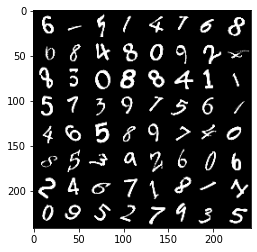

In [21]:
imshow(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


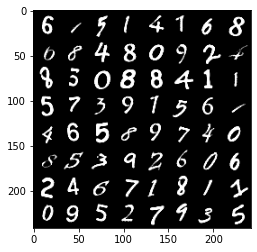

In [22]:
images2 = rotate(images, predicted)
imshow(torchvision.utils.make_grid(images2))